In [4]:
"""
===============================================================================
NOTEBOOK 03: MODEL TRAINING & EVALUATION
===============================================================================

Purpose: Train and evaluate machine learning models for binary accident severity
         prediction using dispatch-time available features.

Models:
1. Logistic Regression (baseline)
2. Random Forest (primary model)
3. Gradient Boosting (comparison)

Evaluation Focus:
- HIGH severity recall (safety-first for emergency dispatch)
- Balanced performance across precision and recall
- Model interpretability through feature importance

Author: Mary Wangoi Mwangi (122174)
Supervisor: Prof. Vincent Omwenga
Date: February 2026
===============================================================================
"""

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import time  
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("NOTEBOOK 03: MODEL TRAINING & EVALUATION")
print("="*70)
print("\n Libraries imported successfully")



# ============================================================================
# LOAD PREPARED DATASETS
# ============================================================================
print("\n" + "="*70)
print("LOADING PREPARED DATASETS FROM NOTEBOOK 02")
print("="*70)

# Load training data (SMOTE-balanced) - add allow_pickle=True
X_train = np.load('../data/features/X_train_balanced.npy', allow_pickle=True)
y_train = np.load('../data/features/y_train_balanced.npy', allow_pickle=True)

# Load validation data (natural distribution)
X_val = np.load('../data/features/X_val.npy', allow_pickle=True)
y_val = np.load('../data/features/y_val.npy', allow_pickle=True)

# Load test data (natural distribution)
X_test = np.load('../data/features/X_test.npy', allow_pickle=True)
y_test = np.load('../data/features/y_test.npy', allow_pickle=True)

# Load feature metadata
feature_metadata = joblib.load('../data/features/feature_metadata.pkl')
feature_names = feature_metadata['feature_names']

print(f"\n Training set loaded:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f" Validation set loaded: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f" Test set loaded:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

# Display class distributions
print("\n" + "="*70)
print("CLASS DISTRIBUTIONS")
print("="*70)

print(f"\nTraining set (SMOTE-balanced):")
print(f"  LOW (0):  {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

print(f"\nValidation set (natural):")
print(f"  LOW (0):  {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_val == 1).sum():,} ({(y_val == 1).mean()*100:.2f}%)")

print(f"\nTest set (natural):")
print(f"  LOW (0):  {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")



# ============================================================================
# FEATURE INVENTORY
# ============================================================================
print("\n" + "="*70)
print("FEATURE INVENTORY")
print("="*70)

print(f"\nTotal features: {len(feature_names)}")
print("\nFeature categories from Notebook 02:")
print("  - Location (2): latitude, longitude")
print("  - Temporal original (6): hour, day, month, year, weekend, etc.")
print("  - Temporal engineered (3): severity rates by hour/day/month")
print("  - Temporal indicators (2): night, rush_hour")
print("  - Spatial (6): crashes at location, risk rates, etc.")
print("  - Weather (5): season, rain risk, daylight, compound risks")
print("  - Road infrastructure (6): road type, intersection, speed, zone, distance")
print("  - Encoded categorical (17): one-hot encoded features")

print("\n Data loaded successfully")
print(" Ready for model training")

NOTEBOOK 03: MODEL TRAINING & EVALUATION

 Libraries imported successfully

LOADING PREPARED DATASETS FROM NOTEBOOK 02

 Training set loaded:   38,072 samples × 41 features
 Validation set loaded: 4,648 samples × 41 features
 Test set loaded:       4,660 samples × 41 features

CLASS DISTRIBUTIONS

Training set (SMOTE-balanced):
  LOW (0):  19,036 (50.00%)
  HIGH (1): 19,036 (50.00%)

Validation set (natural):
  LOW (0):  4,067 (87.50%)
  HIGH (1): 581 (12.50%)

Test set (natural):
  LOW (0):  4,077 (87.49%)
  HIGH (1): 583 (12.51%)

FEATURE INVENTORY

Total features: 41

Feature categories from Notebook 02:
  - Location (2): latitude, longitude
  - Temporal original (6): hour, day, month, year, weekend, etc.
  - Temporal engineered (3): severity rates by hour/day/month
  - Temporal indicators (2): night, rush_hour
  - Spatial (6): crashes at location, risk rates, etc.
  - Weather (5): season, rain risk, daylight, compound risks
  - Road infrastructure (6): road type, intersection, spee

BASELINE MODEL: LOGISTIC REGRESSION

TRAINING LOGISTIC REGRESSION

Model parameters:
  - Solver: lbfgs
  - Max iterations: 1000
  - Class weight: balanced
  - Random state: 42

 Training model...
 Model trained successfully

VALIDATION SET PERFORMANCE

 Overall Metrics:
  Accuracy:  0.7810
  ROC-AUC:   0.5818

 HIGH Severity (Class 1) Metrics:
  Precision: 0.1856
  Recall:    0.2220 ← CRITICAL for emergency dispatch
  F1-Score:  0.2022

 Confusion Matrix:
  True Negatives (LOW predicted LOW):   3,501
  False Positives (LOW predicted HIGH): 566
  False Negatives (HIGH predicted LOW): 452 ← DANGEROUS!
  True Positives (HIGH predicted HIGH):  129

 Under-triage rate: 77.80%
  (HIGH severity crashes predicted as LOW - MUST BE LOW!)

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

     LOW (0)     0.8857    0.8608    0.8731      4067
    HIGH (1)     0.1856    0.2220    0.2022       581

    accuracy                         0.7810      4648
   macro av

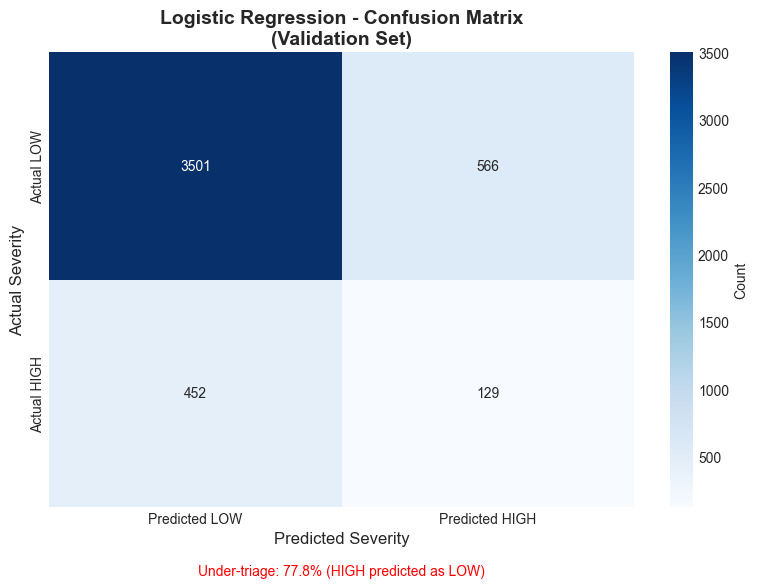


 Figure saved: LR_confusion_matrix.png

LOGISTIC REGRESSION BASELINE SUMMARY

 Key Performance Indicators:
   Validation Accuracy:  0.7810
   HIGH Recall:          0.2220
   HIGH F1-Score:        0.2022
   Under-triage Rate:    77.80%

 Baseline model complete
 This sets the performance floor for tree-based models


In [5]:
"""
SECTION 2: Baseline Model - Logistic Regression

Train a simple Logistic Regression model as baseline.
This establishes minimum expected performance.

Note: Logistic Regression is a linear model, so it may struggle 
with complex non-linear patterns in accident severity prediction.
"""

print("="*70)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*70)

# ============================================================================
# TRAIN LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*70)
print("TRAINING LOGISTIC REGRESSION")
print("="*70)

# Initialize model with balanced class weights (alternative to SMOTE)
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Helps with imbalanced validation/test sets
    solver='lbfgs'
)

print("\nModel parameters:")
print(f"  - Solver: lbfgs")
print(f"  - Max iterations: 1000")
print(f"  - Class weight: balanced")
print(f"  - Random state: 42")

# Train model
print("\n Training model...")
lr_model.fit(X_train, y_train)
print(" Model trained successfully")



# ============================================================================
# EVALUATE ON VALIDATION SET
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

# Make predictions
y_val_pred = lr_model.predict(X_val)
y_val_proba = lr_model.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label=1)
val_recall = recall_score(y_val, y_val_pred, pos_label=1)
val_f1 = f1_score(y_val, y_val_pred, pos_label=1)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"\n Overall Metrics:")
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  ROC-AUC:   {val_roc_auc:.4f}")

print(f"\n HIGH Severity (Class 1) Metrics:")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f} ← CRITICAL for emergency dispatch")
print(f"  F1-Score:  {val_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print(f"\n Confusion Matrix:")
print(f"  True Negatives (LOW predicted LOW):   {cm[0,0]:,}")
print(f"  False Positives (LOW predicted HIGH): {cm[0,1]:,}")
print(f"  False Negatives (HIGH predicted LOW): {cm[1,0]:,} ← DANGEROUS!")
print(f"  True Positives (HIGH predicted HIGH):  {cm[1,1]:,}")

# Calculate under-triage rate (most critical metric for safety)
under_triage_rate = cm[1,0] / (cm[1,0] + cm[1,1]) * 100
print(f"\n Under-triage rate: {under_triage_rate:.2f}%")
print(f"  (HIGH severity crashes predicted as LOW - MUST BE LOW!)")



# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print("\n" + classification_report(y_val, y_val_pred, 
                                   target_names=['LOW (0)', 'HIGH (1)'],
                                   digits=4))



# ============================================================================
# VISUALIZE CONFUSION MATRIX
# ============================================================================
print("="*70)
print("CONFUSION MATRIX VISUALIZATION")
print("="*70)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted LOW', 'Predicted HIGH'],
            yticklabels=['Actual LOW', 'Actual HIGH'],
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_title('Logistic Regression - Confusion Matrix\n(Validation Set)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Actual Severity', fontsize=12)
ax.set_xlabel('Predicted Severity', fontsize=12)

# Add text annotations for interpretability
ax.text(0.5, -0.15, f'Under-triage: {under_triage_rate:.1f}% (HIGH predicted as LOW)', 
        ha='center', transform=ax.transAxes, fontsize=10, color='red')

plt.tight_layout()
plt.savefig('../reports/figures/lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: LR_confusion_matrix.png")



# ============================================================================
# BASELINE SUMMARY
# ============================================================================
print("\n" + "="*70)
print("LOGISTIC REGRESSION BASELINE SUMMARY")
print("="*70)

print(f"\n Key Performance Indicators:")
print(f"   Validation Accuracy:  {val_accuracy:.4f}")
print(f"   HIGH Recall:          {val_recall:.4f}")
print(f"   HIGH F1-Score:        {val_f1:.4f}")
print(f"   Under-triage Rate:    {under_triage_rate:.2f}%")

print("\n Baseline model complete")
print(" This sets the performance floor for tree-based models")

PRIMARY MODEL: RANDOM FOREST

TRAINING RANDOM FOREST

 Parameters:
  - n_estimators: 100 trees
  - max_depth: 20
  - min_samples_split: 10
  - min_samples_leaf: 5
  - max_features: sqrt
  - class_weight: None (SMOTE already balanced data)
  - n_jobs: -1 (all cores)

Training model on 38,072 SMOTE-balanced samples...
 Model trained successfully in 1.54 seconds

VALIDATION SET PERFORMANCE

 Overall Metrics:
  Accuracy:  0.8683
  ROC-AUC:   0.6185

HIGH Severity (Class 1) Metrics:
  Precision: 0.3176
  Recall:    0.0465 ← CRITICAL for emergency dispatch
  F1-Score:  0.0811

Confusion Matrix:
  True Negatives (LOW predicted LOW):   4,009
  False Positives (LOW predicted HIGH): 58
  False Negatives (HIGH predicted LOW): 554 ← DANGEROUS!
  True Positives (HIGH predicted HIGH):  27

 Under-triage rate: 95.35%

COMPARISON: RANDOM FOREST vs LOGISTIC REGRESSION

Metric                    Logistic Reg    Random Forest   Improvement    
-------------------------------------------------------------

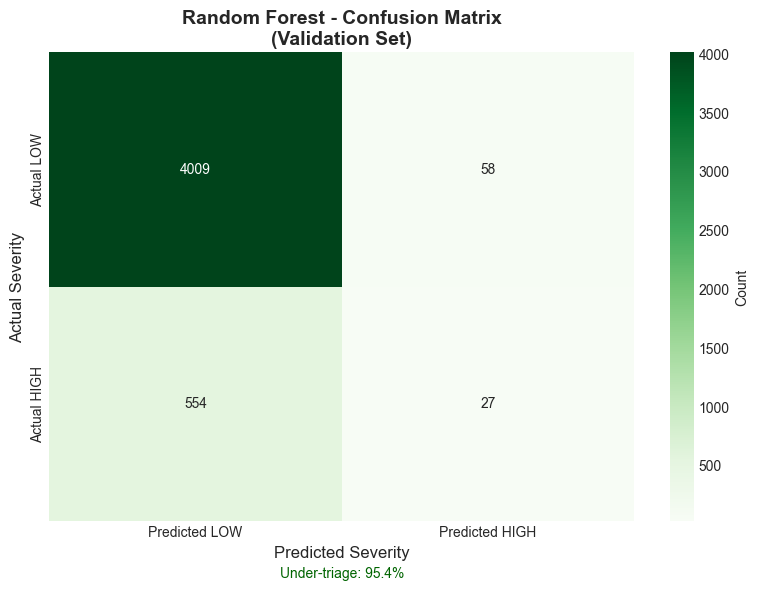


 Figure saved: RF_initial_confusion_matrix.png

RANDOM FOREST INITIAL SUMMARY

 Key Performance Indicators:
   Validation Accuracy:  0.8683
   HIGH Recall:          0.0465
   HIGH F1-Score:        0.0811
   Under-triage Rate:    95.35%

 Random Forest needs tuning to improve over baseline

 Random Forest training complete
 Ready for threshold optimization


In [7]:
"""
SECTION 3: Random Forest - Initial Training

Random Forest is the primary model because:
1. Handles non-linear relationships (unlike Logistic Regression)
2. Robust to different feature scales (no scaling needed)
3. Provides feature importance (interpretability)
4. Works well with imbalanced data after SMOTE
"""

print("="*70)
print("PRIMARY MODEL: RANDOM FOREST")
print("="*70)

# ============================================================================
# TRAIN RANDOM FOREST
# ============================================================================
print("\n" + "="*70)
print("TRAINING RANDOM FOREST")
print("="*70)

# Initialize Random Forest (NO class_weight - SMOTE already balanced data)
rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=20,          
    min_samples_split=10,  
    min_samples_leaf=5,    
    max_features='sqrt',   
    random_state=42,
    n_jobs=-1
)

print("\n Parameters:")
print(f"  - n_estimators: 100 trees")
print(f"  - max_depth: 20")
print(f"  - min_samples_split: 10")
print(f"  - min_samples_leaf: 5")
print(f"  - max_features: sqrt")
print(f"  - class_weight: None (SMOTE already balanced data)")
print(f"  - n_jobs: -1 (all cores)")

# Train model
print("\nTraining model on 38,072 SMOTE-balanced samples...")
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f" Model trained successfully in {training_time:.2f} seconds")



# ============================================================================
# EVALUATE ON VALIDATION SET
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

# Make predictions
y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_precision_rf = precision_score(y_val, y_val_pred_rf, pos_label=1)
val_recall_rf = recall_score(y_val, y_val_pred_rf, pos_label=1)
val_f1_rf = f1_score(y_val, y_val_pred_rf, pos_label=1)
val_roc_auc_rf = roc_auc_score(y_val, y_val_proba_rf)

print(f"\n Overall Metrics:")
print(f"  Accuracy:  {val_accuracy_rf:.4f}")
print(f"  ROC-AUC:   {val_roc_auc_rf:.4f}")

print(f"\nHIGH Severity (Class 1) Metrics:")
print(f"  Precision: {val_precision_rf:.4f}")
print(f"  Recall:    {val_recall_rf:.4f} ← CRITICAL for emergency dispatch")
print(f"  F1-Score:  {val_f1_rf:.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print(f"\nConfusion Matrix:")
print(f"  True Negatives (LOW predicted LOW):   {cm_rf[0,0]:,}")
print(f"  False Positives (LOW predicted HIGH): {cm_rf[0,1]:,}")
print(f"  False Negatives (HIGH predicted LOW): {cm_rf[1,0]:,} ← DANGEROUS!")
print(f"  True Positives (HIGH predicted HIGH):  {cm_rf[1,1]:,}")

# Calculate under-triage rate
under_triage_rf = cm_rf[1,0] / (cm_rf[1,0] + cm_rf[1,1]) * 100
print(f"\n Under-triage rate: {under_triage_rf:.2f}%")



# ============================================================================
# COMPARE WITH LOGISTIC REGRESSION BASELINE
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: RANDOM FOREST vs LOGISTIC REGRESSION")
print("="*70)

print(f"\n{'Metric':<25} {'Logistic Reg':<15} {'Random Forest':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {val_accuracy:<15.4f} {val_accuracy_rf:<15.4f} {(val_accuracy_rf-val_accuracy)*100:>+14.2f}%")
print(f"{'ROC-AUC':<25} {val_roc_auc:<15.4f} {val_roc_auc_rf:<15.4f} {(val_roc_auc_rf-val_roc_auc)*100:>+14.2f}%")
print(f"{'HIGH Precision':<25} {val_precision:<15.4f} {val_precision_rf:<15.4f} {(val_precision_rf-val_precision)*100:>+14.2f}%")
print(f"{'HIGH Recall':<25} {val_recall:<15.4f} {val_recall_rf:<15.4f} {(val_recall_rf-val_recall)*100:>+14.2f}%")
print(f"{'HIGH F1-Score':<25} {val_f1:<15.4f} {val_f1_rf:<15.4f} {(val_f1_rf-val_f1)*100:>+14.2f}%")
print(f"{'Under-triage Rate':<25} {under_triage_rate:<15.2f} {under_triage_rf:<15.2f} {(under_triage_rf-under_triage_rate):>+14.2f}%")



# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print("\n" + classification_report(y_val, y_val_pred_rf, 
                                   target_names=['LOW (0)', 'HIGH (1)'],
                                   digits=4))



# ============================================================================
# VISUALIZE CONFUSION MATRIX
# ============================================================================
print("="*70)
print("CONFUSION MATRIX VISUALIZATION")
print("="*70)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted LOW', 'Predicted HIGH'],
            yticklabels=['Actual LOW', 'Actual HIGH'],
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_title('Random Forest - Confusion Matrix\n(Validation Set)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Actual Severity', fontsize=12)
ax.set_xlabel('Predicted Severity', fontsize=12)
ax.text(0.5, -0.12, f'Under-triage: {under_triage_rf:.1f}%', 
        ha='center', transform=ax.transAxes, fontsize=10, color='darkgreen')

plt.tight_layout()
plt.savefig('../reports/figures/rf_initial_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: RF_initial_confusion_matrix.png")



# ============================================================================
# RANDOM FOREST SUMMARY
# ============================================================================
print("\n" + "="*70)
print("RANDOM FOREST INITIAL SUMMARY")
print("="*70)

print(f"\n Key Performance Indicators:")
print(f"   Validation Accuracy:  {val_accuracy_rf:.4f}")
print(f"   HIGH Recall:          {val_recall_rf:.4f}")
print(f"   HIGH F1-Score:        {val_f1_rf:.4f}")
print(f"   Under-triage Rate:    {under_triage_rf:.2f}%")

if val_recall_rf > val_recall:
    improvement = (val_recall_rf - val_recall) / val_recall * 100
    print(f"\n Random Forest improves HIGH recall by {improvement:.1f}% over baseline!")
else:
    print(f"\n Random Forest needs tuning to improve over baseline")

print("\n Random Forest training complete")
print(" Ready for threshold optimization")

DECISION THRESHOLD OPTIMIZATION

TESTING DIFFERENT DECISION THRESHOLDS

Threshold    Accuracy   Precision   Recall     F1-Score   Under-triage
---------------------------------------------------------------------------
0.10         0.2803     0.1394      0.9191     0.2420     8.09        %
0.15         0.4359     0.1509      0.7590     0.2517     24.10       %
0.20         0.5856     0.1659      0.5749     0.2575     42.51       %
0.25         0.6966     0.1819      0.4079     0.2516     59.21       %
0.30         0.7756     0.2083      0.2840     0.2403     71.60       %
0.35         0.8206     0.2291      0.1842     0.2042     81.58       %
0.40         0.8429     0.2386      0.1170     0.1570     88.30       %
0.45         0.8593     0.2761      0.0775     0.1210     92.25       %
0.50         0.8683     0.3176      0.0465     0.0811     95.35       %
0.55         0.8726     0.3778      0.0293     0.0543     97.07       %
0.60         0.8750     0.5000      0.0224     0.0428     97.

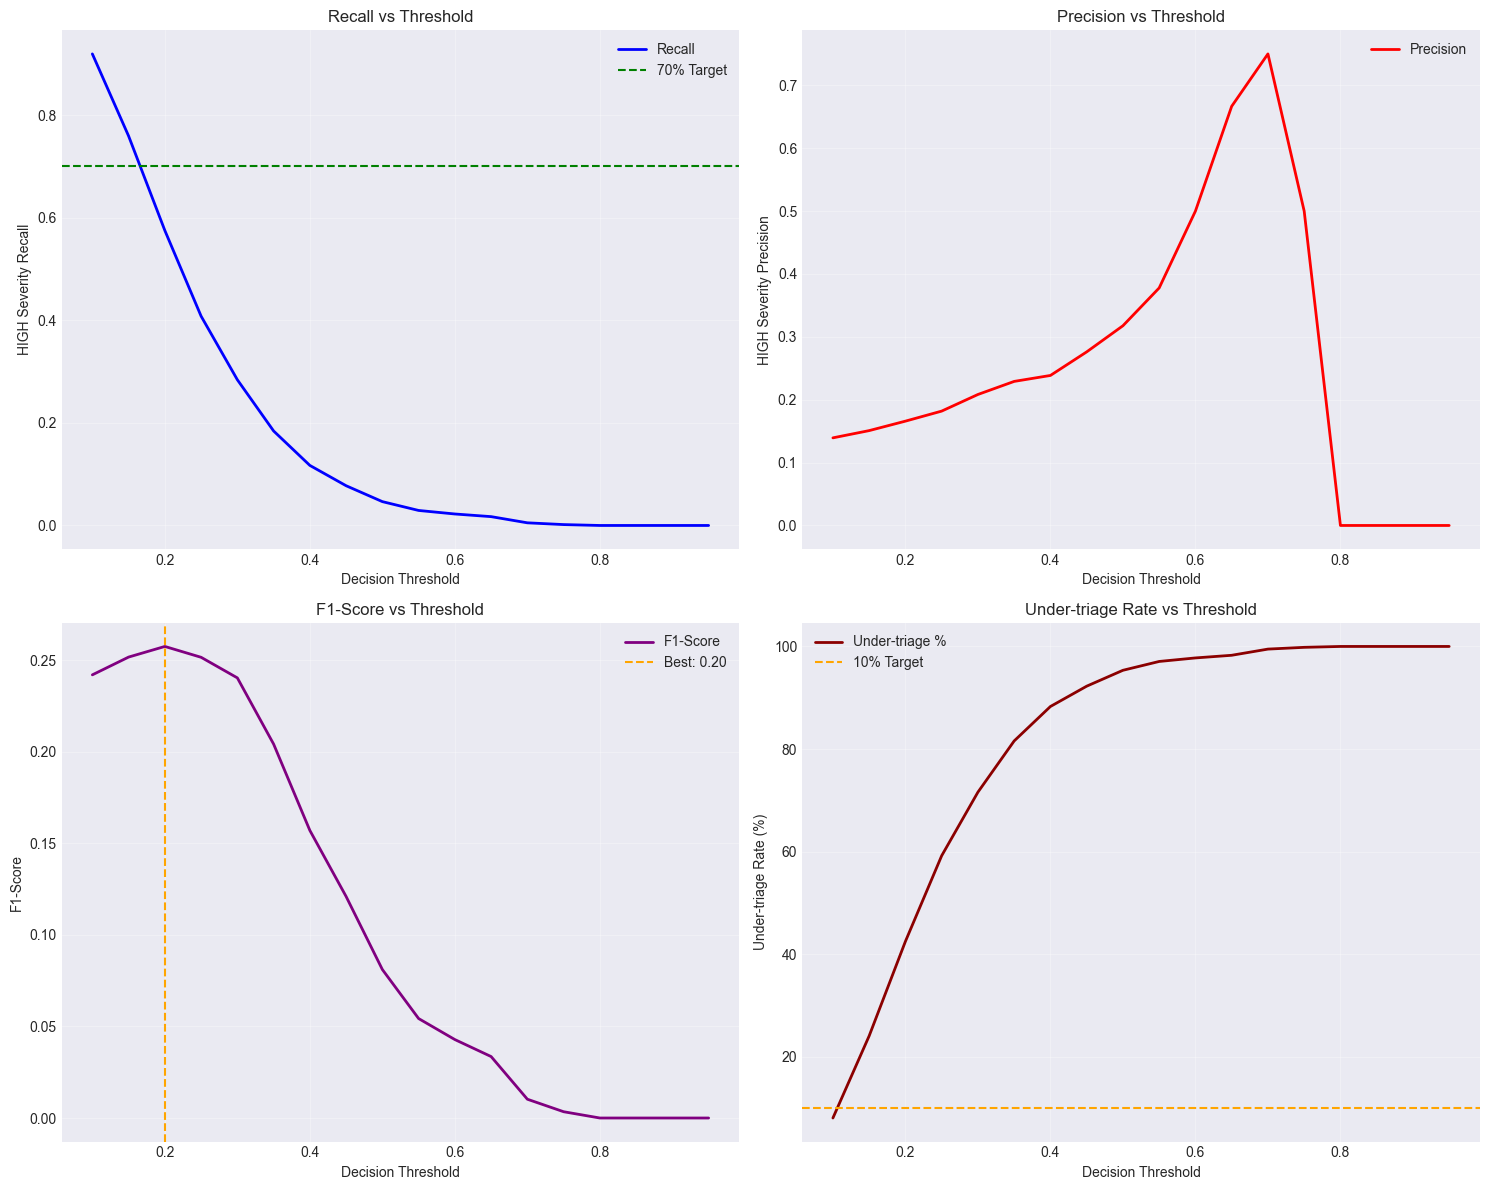


 Figure saved: threshold_optimization.png

APPLYING OPTIMAL THRESHOLD

 Using threshold: 0.20
(Optimized for balanced F1-score)

 Optimized Confusion Matrix:
  True Negatives:  2,388
  False Positives: 1,679
  False Negatives: 247
  True Positives:  334

 Optimized Performance:
  Accuracy:  0.5856
  Precision: 0.1659
  Recall:    0.5749
  F1-Score:  0.2575
  Under-triage: 42.51%

 Threshold optimization complete
 Optimal threshold: 0.20


In [8]:
"""
SECTION 4: Decision Threshold Optimization

The default threshold (0.5) optimizes for accuracy, not safety.
For emergency dispatch, we need to optimize for HIGH severity RECALL.

Test different thresholds and find the one that:
1. Maximizes HIGH recall (catches urgent cases)
2. Maintains acceptable precision (avoids too many false alarms)
3. Minimizes under-triage rate (safety-first!)
"""

print("="*70)
print("DECISION THRESHOLD OPTIMIZATION")
print("="*70)

# ============================================================================
# TEST DIFFERENT THRESHOLDS
# ============================================================================
print("\n" + "="*70)
print("TESTING DIFFERENT DECISION THRESHOLDS")
print("="*70)

# Get prediction probabilities (already computed)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Test thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

print(f"\n{'Threshold':<12} {'Accuracy':<10} {'Precision':<11} {'Recall':<10} {'F1-Score':<10} {'Under-triage':<12}")
print("-" * 75)

for threshold in thresholds:
    # Apply threshold
    y_pred_thresh = (y_val_proba_rf >= threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    
    # Calculate under-triage
    cm_thresh = confusion_matrix(y_val, y_pred_thresh)
    under_triage = cm_thresh[1,0] / (cm_thresh[1,0] + cm_thresh[1,1]) * 100 if (cm_thresh[1,0] + cm_thresh[1,1]) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'under_triage': under_triage
    })
    
    print(f"{threshold:<12.2f} {acc:<10.4f} {prec:<11.4f} {rec:<10.4f} {f1:<10.4f} {under_triage:<12.2f}%")

results_df = pd.DataFrame(results)



# ============================================================================
# FIND OPTIMAL THRESHOLDS
# ============================================================================
print("\n" + "="*70)
print("OPTIMAL THRESHOLDS FOR DIFFERENT OBJECTIVES")
print("="*70)

# Threshold that maximizes F1-score
best_f1_idx = results_df['f1'].idxmax()
best_f1_threshold = results_df.loc[best_f1_idx, 'threshold']
best_f1_score = results_df.loc[best_f1_idx, 'f1']

print(f"\n1. BEST F1-SCORE (balanced performance):")
print(f"   Threshold: {best_f1_threshold:.2f}")
print(f"   F1-Score: {best_f1_score:.4f}")
print(f"   Recall: {results_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"   Under-triage: {results_df.loc[best_f1_idx, 'under_triage']:.2f}%")

# Threshold that achieves HIGH recall ≥ 70%
high_recall_thresholds = results_df[results_df['recall'] >= 0.70]
if len(high_recall_thresholds) > 0:
    # Among those, pick the one with best precision
    best_safety_idx = high_recall_thresholds['precision'].idxmax()
    best_safety_threshold = high_recall_thresholds.loc[best_safety_idx, 'threshold']
    
    print(f"\n2. SAFETY-FIRST (≥70% recall):")
    print(f"   Threshold: {best_safety_threshold:.2f}")
    print(f"   Recall: {high_recall_thresholds.loc[best_safety_idx, 'recall']:.4f}")
    print(f"   Precision: {high_recall_thresholds.loc[best_safety_idx, 'precision']:.4f}")
    print(f"   Under-triage: {high_recall_thresholds.loc[best_safety_idx, 'under_triage']:.2f}%")
else:
    # If no threshold achieves 70%, find best recall
    best_recall_idx = results_df['recall'].idxmax()
    best_recall_threshold = results_df.loc[best_recall_idx, 'threshold']
    
    print(f"\n2. MAXIMUM RECALL (safety-first):")
    print(f"   Threshold: {best_recall_threshold:.2f}")
    print(f"   Recall: {results_df.loc[best_recall_idx, 'recall']:.4f}")
    print(f"   Precision: {results_df.loc[best_recall_idx, 'precision']:.4f}")
    print(f"   Under-triage: {results_df.loc[best_recall_idx, 'under_triage']:.2f}%")



# ============================================================================
# VISUALIZE THRESHOLD TRADE-OFFS
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD TRADE-OFF VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Recall vs Threshold
axes[0,0].plot(results_df['threshold'], results_df['recall'], 'b-', linewidth=2, label='Recall')
axes[0,0].axhline(y=0.7, color='g', linestyle='--', label='70% Target')
axes[0,0].set_xlabel('Decision Threshold')
axes[0,0].set_ylabel('HIGH Severity Recall')
axes[0,0].set_title('Recall vs Threshold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Plot 2: Precision vs Threshold  
axes[0,1].plot(results_df['threshold'], results_df['precision'], 'r-', linewidth=2, label='Precision')
axes[0,1].set_xlabel('Decision Threshold')
axes[0,1].set_ylabel('HIGH Severity Precision')
axes[0,1].set_title('Precision vs Threshold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Plot 3: F1-Score vs Threshold
axes[1,0].plot(results_df['threshold'], results_df['f1'], 'purple', linewidth=2, label='F1-Score')
axes[1,0].axvline(x=best_f1_threshold, color='orange', linestyle='--', label=f'Best: {best_f1_threshold:.2f}')
axes[1,0].set_xlabel('Decision Threshold')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].set_title('F1-Score vs Threshold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Plot 4: Under-triage vs Threshold
axes[1,1].plot(results_df['threshold'], results_df['under_triage'], 'darkred', linewidth=2, label='Under-triage %')
axes[1,1].axhline(y=10, color='orange', linestyle='--', label='10% Target')
axes[1,1].set_xlabel('Decision Threshold')
axes[1,1].set_ylabel('Under-triage Rate (%)')
axes[1,1].set_title('Under-triage Rate vs Threshold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: threshold_optimization.png")



# ============================================================================
# APPLY OPTIMAL THRESHOLD
# ============================================================================
print("\n" + "="*70)
print("APPLYING OPTIMAL THRESHOLD")
print("="*70)

# Use F1-optimal threshold
optimal_threshold = best_f1_threshold
y_val_pred_optimal = (y_val_proba_rf >= optimal_threshold).astype(int)

print(f"\n Using threshold: {optimal_threshold:.2f}")
print("(Optimized for balanced F1-score)")

# Calculate final metrics
cm_optimal = confusion_matrix(y_val, y_val_pred_optimal)
print(f"\n Optimized Confusion Matrix:")
print(f"  True Negatives:  {cm_optimal[0,0]:,}")
print(f"  False Positives: {cm_optimal[0,1]:,}")
print(f"  False Negatives: {cm_optimal[1,0]:,}")
print(f"  True Positives:  {cm_optimal[1,1]:,}")

acc_optimal = accuracy_score(y_val, y_val_pred_optimal)
prec_optimal = precision_score(y_val, y_val_pred_optimal, pos_label=1)
rec_optimal = recall_score(y_val, y_val_pred_optimal, pos_label=1)
f1_optimal = f1_score(y_val, y_val_pred_optimal, pos_label=1)
under_triage_optimal = cm_optimal[1,0] / (cm_optimal[1,0] + cm_optimal[1,1]) * 100

print(f"\n Optimized Performance:")
print(f"  Accuracy:  {acc_optimal:.4f}")
print(f"  Precision: {prec_optimal:.4f}")
print(f"  Recall:    {rec_optimal:.4f}")
print(f"  F1-Score:  {f1_optimal:.4f}")
print(f"  Under-triage: {under_triage_optimal:.2f}%")

print("\n Threshold optimization complete")
print(f" Optimal threshold: {optimal_threshold:.2f}")

COMPARISON MODEL: GRADIENT BOOSTING

TRAINING GRADIENT BOOSTING

Parameters:
  - n_estimators: 100
  - learning_rate: 0.1
  - max_depth: 5 (shallower than RF)
  - subsample: 0.8
  - NO class_weight (SMOTE already balanced data)

Training model on 38,072 SMOTE-balanced samples...
 Model trained successfully in 2.94 seconds

VALIDATION PERFORMANCE (Threshold = 0.5)

Overall Metrics:
  Accuracy:  0.8739
  ROC-AUC:   0.6220

HIGH Severity (Class 1) Metrics:
  Precision: 0.4419
  Recall:    0.0327
  F1-Score:  0.0609

Confusion Matrix:
  True Negatives:  4,043
  False Positives: 24
  False Negatives: 562
  True Positives:  19

 Under-triage rate: 96.73%

OPTIMIZING THRESHOLD FOR GRADIENT BOOSTING

Optimal threshold (best F1): 0.25
  F1-Score: 0.2636
  Recall:   0.4389
  Under-triage: 56.11%

MODEL COMPARISON (WITH OPTIMAL THRESHOLDS)

              Model  Threshold  Accuracy  Precision   Recall  F1-Score  Under-triage
Logistic Regression       0.50  0.780981   0.185612 0.222031  0.202194   

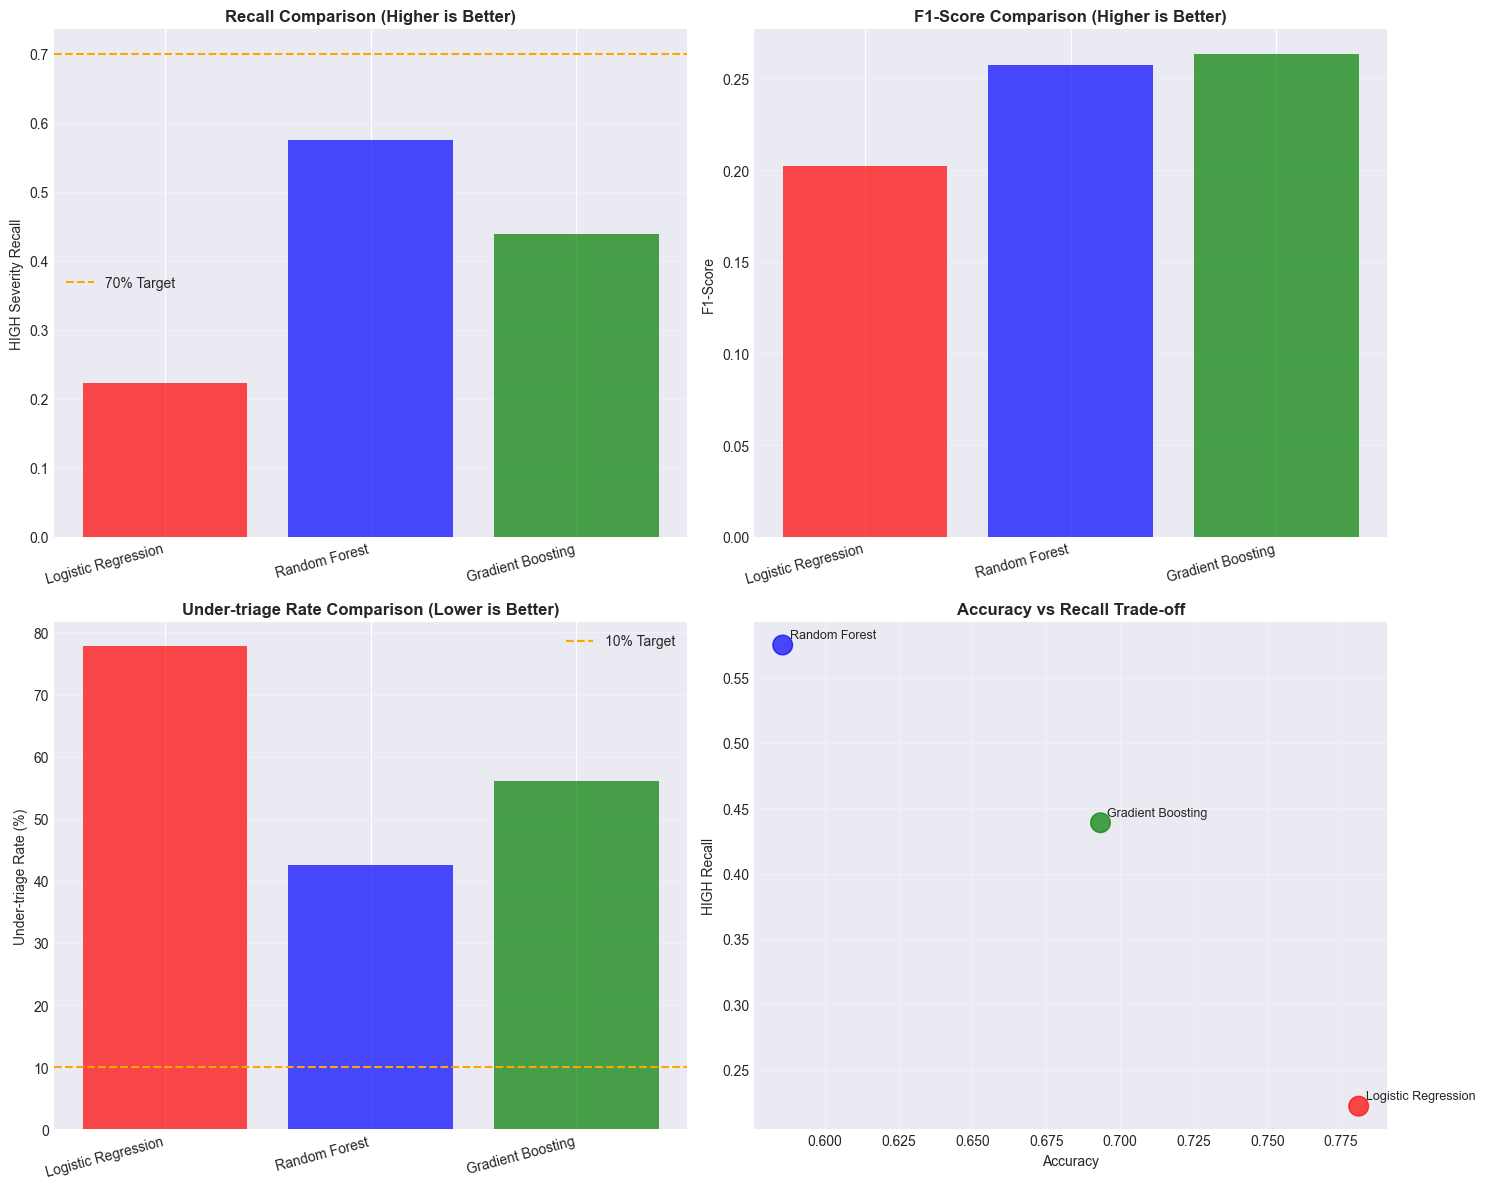


 Figure saved: model_comparison.png

GRADIENT BOOSTING SUMMARY

 Optimized Performance (threshold=0.25):
   Accuracy:  0.6934
   Precision: 0.1883
   Recall:    0.4389
   F1-Score:  0.2636
   Under-triage: 56.11%

 Gradient Boosting training complete
All three models trained and compared


In [9]:
"""
SECTION 5: Gradient Boosting Classifier

Gradient Boosting builds trees sequentially, where each tree corrects
the errors of previous trees. This often achieves higher accuracy than
Random Forest, but takes longer to train.

Compare:
- Training time
- Prediction performance
- Optimal threshold
"""

print("="*70)
print("COMPARISON MODEL: GRADIENT BOOSTING")
print("="*70)

# ============================================================================
# TRAIN GRADIENT BOOSTING WITH REASONABLE PARAMETERS
# ============================================================================
print("\n" + "="*70)
print("TRAINING GRADIENT BOOSTING")
print("="*70)

# Initialize Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Shrinks contribution of each tree
    max_depth=5,           # Maximum depth of trees (shallower than RF)
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    subsample=0.8          # Fraction of samples for each tree
)

print("\nParameters:")
print(f"  - n_estimators: 100")
print(f"  - learning_rate: 0.1")
print(f"  - max_depth: 5 (shallower than RF)")
print(f"  - subsample: 0.8")
print(f"  - NO class_weight (SMOTE already balanced data)")

# Train model
print("\nTraining model on 38,072 SMOTE-balanced samples...")
start_time = time.time()

gb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f" Model trained successfully in {training_time:.2f} seconds")



# ============================================================================
# EVALUATE ON VALIDATION SET (Default threshold = 0.5)
# ============================================================================
print("\n" + "="*70)
print("VALIDATION PERFORMANCE (Threshold = 0.5)")
print("="*70)

# Make predictions
y_val_pred_gb = gb_model.predict(X_val)
y_val_proba_gb = gb_model.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy_gb = accuracy_score(y_val, y_val_pred_gb)
val_precision_gb = precision_score(y_val, y_val_pred_gb, pos_label=1)
val_recall_gb = recall_score(y_val, y_val_pred_gb, pos_label=1)
val_f1_gb = f1_score(y_val, y_val_pred_gb, pos_label=1)
val_roc_auc_gb = roc_auc_score(y_val, y_val_proba_gb)

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {val_accuracy_gb:.4f}")
print(f"  ROC-AUC:   {val_roc_auc_gb:.4f}")

print(f"\nHIGH Severity (Class 1) Metrics:")
print(f"  Precision: {val_precision_gb:.4f}")
print(f"  Recall:    {val_recall_gb:.4f}")
print(f"  F1-Score:  {val_f1_gb:.4f}")

# Confusion matrix
cm_gb = confusion_matrix(y_val, y_val_pred_gb)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm_gb[0,0]:,}")
print(f"  False Positives: {cm_gb[0,1]:,}")
print(f"  False Negatives: {cm_gb[1,0]:,}")
print(f"  True Positives:  {cm_gb[1,1]:,}")

under_triage_gb = cm_gb[1,0] / (cm_gb[1,0] + cm_gb[1,1]) * 100
print(f"\n Under-triage rate: {under_triage_gb:.2f}%")



# ============================================================================
# OPTIMIZE THRESHOLD FOR GRADIENT BOOSTING
# ============================================================================
print("\n" + "="*70)
print("OPTIMIZING THRESHOLD FOR GRADIENT BOOSTING")
print("="*70)

# Test thresholds
thresholds_gb = np.arange(0.1, 1.0, 0.05)
results_gb = []

for threshold in thresholds_gb:
    y_pred_thresh = (y_val_proba_gb >= threshold).astype(int)
    
    acc = accuracy_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    
    cm_thresh = confusion_matrix(y_val, y_pred_thresh)
    under = cm_thresh[1,0] / (cm_thresh[1,0] + cm_thresh[1,1]) * 100 if (cm_thresh[1,0] + cm_thresh[1,1]) > 0 else 0
    
    results_gb.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'under_triage': under
    })

results_gb_df = pd.DataFrame(results_gb)

# Find optimal threshold (best F1)
best_f1_idx_gb = results_gb_df['f1'].idxmax()
optimal_threshold_gb = results_gb_df.loc[best_f1_idx_gb, 'threshold']

print(f"\nOptimal threshold (best F1): {optimal_threshold_gb:.2f}")
print(f"  F1-Score: {results_gb_df.loc[best_f1_idx_gb, 'f1']:.4f}")
print(f"  Recall:   {results_gb_df.loc[best_f1_idx_gb, 'recall']:.4f}")
print(f"  Under-triage: {results_gb_df.loc[best_f1_idx_gb, 'under_triage']:.2f}%")

# Apply optimal threshold
y_val_pred_gb_optimal = (y_val_proba_gb >= optimal_threshold_gb).astype(int)

acc_gb_opt = accuracy_score(y_val, y_val_pred_gb_optimal)
prec_gb_opt = precision_score(y_val, y_val_pred_gb_optimal, pos_label=1)
rec_gb_opt = recall_score(y_val, y_val_pred_gb_optimal, pos_label=1)
f1_gb_opt = f1_score(y_val, y_val_pred_gb_optimal, pos_label=1)

cm_gb_opt = confusion_matrix(y_val, y_val_pred_gb_optimal)
under_gb_opt = cm_gb_opt[1,0] / (cm_gb_opt[1,0] + cm_gb_opt[1,1]) * 100



# ============================================================================
# COMPARE ALL MODELS WITH OPTIMAL THRESHOLDS
# ============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON (WITH OPTIMAL THRESHOLDS)")
print("="*70)

comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Threshold': [0.5, optimal_threshold, optimal_threshold_gb],
    'Accuracy': [val_accuracy, acc_optimal, acc_gb_opt],
    'Precision': [val_precision, prec_optimal, prec_gb_opt],
    'Recall': [val_recall, rec_optimal, rec_gb_opt],
    'F1-Score': [val_f1, f1_optimal, f1_gb_opt],
    'Under-triage': [under_triage_rate, under_triage_optimal, under_gb_opt]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + comparison_df.to_string(index=False))

# Find best model by F1-score
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   Recall: {comparison_df.loc[best_model_idx, 'Recall']:.4f}")
print(f"   Under-triage: {comparison_df.loc[best_model_idx, 'Under-triage']:.2f}%")



# ============================================================================
# VISUALIZE MODEL COMPARISON
# ============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models = comparison_df['Model'].tolist()
x_pos = np.arange(len(models))

# Plot 1: Recall comparison
axes[0,0].bar(x_pos, comparison_df['Recall'], color=['red', 'blue', 'green'], alpha=0.7)
axes[0,0].set_ylabel('HIGH Severity Recall')
axes[0,0].set_title('Recall Comparison (Higher is Better)', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(models, rotation=15, ha='right')
axes[0,0].axhline(y=0.7, color='orange', linestyle='--', label='70% Target')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)


# Plot 2: F1-Score comparison
axes[0,1].bar(x_pos, comparison_df['F1-Score'], color=['red', 'blue', 'green'], alpha=0.7)
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_title('F1-Score Comparison (Higher is Better)', fontweight='bold')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(models, rotation=15, ha='right')
axes[0,1].grid(axis='y', alpha=0.3)


# Plot 3: Under-triage comparison
axes[1,0].bar(x_pos, comparison_df['Under-triage'], color=['red', 'blue', 'green'], alpha=0.7)
axes[1,0].set_ylabel('Under-triage Rate (%)')
axes[1,0].set_title('Under-triage Rate Comparison (Lower is Better)', fontweight='bold')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(models, rotation=15, ha='right')
axes[1,0].axhline(y=10, color='orange', linestyle='--', label='10% Target')
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)


# Plot 4: Accuracy vs Recall scatter
axes[1,1].scatter(comparison_df['Accuracy'], comparison_df['Recall'], 
                 s=200, c=['red', 'blue', 'green'], alpha=0.7)
for i, model in enumerate(models):
    axes[1,1].annotate(model, 
                      (comparison_df.loc[i, 'Accuracy'], comparison_df.loc[i, 'Recall']),
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1,1].set_xlabel('Accuracy')
axes[1,1].set_ylabel('HIGH Recall')
axes[1,1].set_title('Accuracy vs Recall Trade-off', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved: model_comparison.png")



# ============================================================================
# GRADIENT BOOSTING SUMMARY
# ============================================================================
print("\n" + "="*70)
print("GRADIENT BOOSTING SUMMARY")
print("="*70)

print(f"\n Optimized Performance (threshold={optimal_threshold_gb:.2f}):")
print(f"   Accuracy:  {acc_gb_opt:.4f}")
print(f"   Precision: {prec_gb_opt:.4f}")
print(f"   Recall:    {rec_gb_opt:.4f}")
print(f"   F1-Score:  {f1_gb_opt:.4f}")
print(f"   Under-triage: {under_gb_opt:.2f}%")

print("\n Gradient Boosting training complete")
print("All three models trained and compared")

In [10]:
"""
SECTION 6: Hyperparameter Tuning - Random Forest

The initial Random Forest used reasonable default parameters, but I'm 
optimizing them using Grid Search with cross-validation on the training set.

Tune:
- n_estimators: Number of trees
- max_depth: Maximum tree depth
- min_samples_split: Minimum samples to split a node
- min_samples_leaf: Minimum samples in leaf node
- max_features: Features to consider at each split

This may take 5-10 minutes to run due to cross-validation.
"""

print("="*70)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*70)

# ============================================================================
# DEFINE PARAMETER GRID
# ============================================================================
print("\n" + "="*70)
print("DEFINING PARAMETER GRID")
print("="*70)

# Define parameter grid (limited to keep runtime reasonable)
param_grid = {
    'n_estimators': [100, 200],           # Number of trees
    'max_depth': [15, 20, 25],            # Tree depth
    'min_samples_split': [5, 10],         # Min samples to split
    'min_samples_leaf': [2, 5],           # Min samples in leaf
    'max_features': ['sqrt', 'log2']      # Features per split
}

print("\n Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print(f"\n Total parameter combinations: {total_combinations}")
print(f"With 3-fold CV: {total_combinations * 3} model fits")



# ============================================================================
# PERFORM GRID SEARCH WITH CROSS-VALIDATION
# ============================================================================
print("\n" + "="*70)
print("RUNNING GRID SEARCH (This may take 5-10 minutes...)")
print("="*70)

# Initialize Grid Search
# Note: We use F1-score as the scoring metric (better for imbalanced classes than accuracy)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation (faster than 5-fold)
    scoring='f1',            # Optimize for F1-score
    verbose=1,               # Show progress
    n_jobs=-1                # Use all CPU cores
)

print("\n Starting grid search...")
print("Scoring metric: F1-score (better for imbalanced data)")
print("Cross-validation: 3-fold")

start_time = time.time()

# Fit grid search on training data
grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
print(f"\n Grid search completed in {tuning_time:.2f} seconds ({tuning_time/60:.2f} minutes)")



# ============================================================================
# EXTRACT BEST PARAMETERS
# ============================================================================
print("\n" + "="*70)
print("BEST PARAMETERS FOUND")
print("="*70)

best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print("\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1-score: {best_cv_score:.4f}")

# Get the best model
rf_tuned = grid_search.best_estimator_

print("\n Best model extracted from grid search")



# ============================================================================
# EVALUATE TUNED MODEL ON VALIDATION SET
# ============================================================================
print("\n" + "="*70)
print("EVALUATING TUNED MODEL ON VALIDATION SET")
print("="*70)

# Make predictions with default threshold (0.5)
y_val_pred_tuned = rf_tuned.predict(X_val)
y_val_proba_tuned = rf_tuned.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
val_precision_tuned = precision_score(y_val, y_val_pred_tuned, pos_label=1, zero_division=0)
val_recall_tuned = recall_score(y_val, y_val_pred_tuned, pos_label=1)
val_f1_tuned = f1_score(y_val, y_val_pred_tuned, pos_label=1, zero_division=0)
val_roc_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)

print(f"\n Default threshold (0.5) performance:")
print(f"  Accuracy:  {val_accuracy_tuned:.4f}")
print(f"  Precision: {val_precision_tuned:.4f}")
print(f"  Recall:    {val_recall_tuned:.4f}")
print(f"  F1-Score:  {val_f1_tuned:.4f}")



# ============================================================================
# OPTIMIZE THRESHOLD FOR TUNED MODEL
# ============================================================================
print("\n" + "="*70)
print("OPTIMIZING THRESHOLD FOR TUNED MODEL")
print("="*70)

# Test thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
results_tuned = []

for threshold in thresholds:
    y_pred_thresh = (y_val_proba_tuned >= threshold).astype(int)
    
    acc = accuracy_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_val, y_pred_thresh, pos_label=1, zero_division=0)
    
    cm_thresh = confusion_matrix(y_val, y_pred_thresh)
    under = cm_thresh[1,0] / (cm_thresh[1,0] + cm_thresh[1,1]) * 100 if (cm_thresh[1,0] + cm_thresh[1,1]) > 0 else 0
    
    results_tuned.append({
        'threshold': threshold,
        'recall': rec,
        'f1': f1,
        'under_triage': under
    })

results_tuned_df = pd.DataFrame(results_tuned)

# Find optimal threshold
best_f1_idx = results_tuned_df['f1'].idxmax()
optimal_threshold_tuned = results_tuned_df.loc[best_f1_idx, 'threshold']

print(f"\nOptimal threshold: {optimal_threshold_tuned:.2f}")
print(f"  F1-Score: {results_tuned_df.loc[best_f1_idx, 'f1']:.4f}")
print(f"  Recall:   {results_tuned_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"  Under-triage: {results_tuned_df.loc[best_f1_idx, 'under_triage']:.2f}%")

# Apply optimal threshold
y_val_pred_tuned_opt = (y_val_proba_tuned >= optimal_threshold_tuned).astype(int)

acc_tuned_opt = accuracy_score(y_val, y_val_pred_tuned_opt)
prec_tuned_opt = precision_score(y_val, y_val_pred_tuned_opt, pos_label=1)
rec_tuned_opt = recall_score(y_val, y_val_pred_tuned_opt, pos_label=1)
f1_tuned_opt = f1_score(y_val, y_val_pred_tuned_opt, pos_label=1)

cm_tuned_opt = confusion_matrix(y_val, y_val_pred_tuned_opt)
under_tuned_opt = cm_tuned_opt[1,0] / (cm_tuned_opt[1,0] + cm_tuned_opt[1,1]) * 100



# ============================================================================
# COMPARE: INITIAL vs TUNED MODEL
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: INITIAL vs TUNED RANDOM FOREST")
print("="*70)

print(f"\n{'Metric':<25} {'Initial RF':<15} {'Tuned RF':<15} {'Change':<15}")
print("-" * 70)
print(f"{'Optimal Threshold':<25} {optimal_threshold:<15.2f} {optimal_threshold_tuned:<15.2f} {'':<15}")
print(f"{'Accuracy':<25} {acc_optimal:<15.4f} {acc_tuned_opt:<15.4f} {(acc_tuned_opt-acc_optimal)*100:>+14.2f}%")
print(f"{'Precision':<25} {prec_optimal:<15.4f} {prec_tuned_opt:<15.4f} {(prec_tuned_opt-prec_optimal)*100:>+14.2f}%")
print(f"{'Recall':<25} {rec_optimal:<15.4f} {rec_tuned_opt:<15.4f} {(rec_tuned_opt-rec_optimal)*100:>+14.2f}%")
print(f"{'F1-Score':<25} {f1_optimal:<15.4f} {f1_tuned_opt:<15.4f} {(f1_tuned_opt-f1_optimal)*100:>+14.2f}%")
print(f"{'Under-triage Rate':<25} {under_triage_optimal:<15.2f} {under_tuned_opt:<15.2f} {(under_tuned_opt-under_triage_optimal):>+14.2f}%")



# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*70)

print(f"\n Tuned Model Performance (threshold={optimal_threshold_tuned:.2f}):")
print(f"   Accuracy:  {acc_tuned_opt:.4f}")
print(f"   Precision: {prec_tuned_opt:.4f}")
print(f"   Recall:    {rec_tuned_opt:.4f}")
print(f"   F1-Score:  {f1_tuned_opt:.4f}")
print(f"   Under-triage: {under_tuned_opt:.2f}%")

if rec_tuned_opt > rec_optimal:
    improvement = (rec_tuned_opt - rec_optimal) / rec_optimal * 100
    print(f"\n Tuning improved recall by {improvement:.1f}%!")
elif rec_tuned_opt == rec_optimal:
    print(f"\n Tuning maintained performance (no improvement, but validated params)")
else:
    decline = (rec_optimal - rec_tuned_opt) / rec_optimal * 100
    print(f"\n Tuning decreased recall by {decline:.1f}% (will use initial model)")

# Update rf_model to use tuned version if better
if rec_tuned_opt >= rec_optimal:
    rf_model = rf_tuned
    optimal_threshold = optimal_threshold_tuned
    print("\n Updated best model to tuned version")
else:
    print("\n Keeping initial model (better performance)")

print("\n Hyperparameter tuning complete")
print(" Ready for final test set evaluation")

HYPERPARAMETER TUNING - RANDOM FOREST

DEFINING PARAMETER GRID

 Parameter grid:
  n_estimators: [100, 200]
  max_depth: [15, 20, 25]
  min_samples_split: [5, 10]
  min_samples_leaf: [2, 5]
  max_features: ['sqrt', 'log2']

 Total parameter combinations: 48
With 3-fold CV: 144 model fits

RUNNING GRID SEARCH (This may take 5-10 minutes...)

 Starting grid search...
Scoring metric: F1-score (better for imbalanced data)
Cross-validation: 3-fold
Fitting 3 folds for each of 48 candidates, totalling 144 fits

 Grid search completed in 313.45 seconds (5.22 minutes)

BEST PARAMETERS FOUND

Best parameters:
  max_depth: 25
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100

Best cross-validation F1-score: 0.9037

 Best model extracted from grid search

EVALUATING TUNED MODEL ON VALIDATION SET

 Default threshold (0.5) performance:
  Accuracy:  0.8670
  Precision: 0.2967
  Recall:    0.0465
  F1-Score:  0.0804

OPTIMIZING THRESHOLD FOR TUNED MODEL

Optimal thr